In [91]:
import numpy as np
from scipy import optimize
import pandas as pd
from scipy.stats import norm
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.special import gamma
from math import pi
#pip install fbm==0.1.0
from fbm import FBM

In [93]:
f = FBM(n=252, hurst=0.7, length=1, method='daviesharte')
"""For fastest performance use the Davies and Harte method. It is much faster than both other methods especially for larger increment quantities.
Note that the Davies and Harte method can fail if the Hurst parameter hurst is close to 1 and there are a small amount of increments n
"""
# Generate a fBm realization
fbm_sample = f.fbm()

# Get the times associated with the fBm
times = f.times()

In [24]:
fbm_sample.shape
times.shape[0]

253

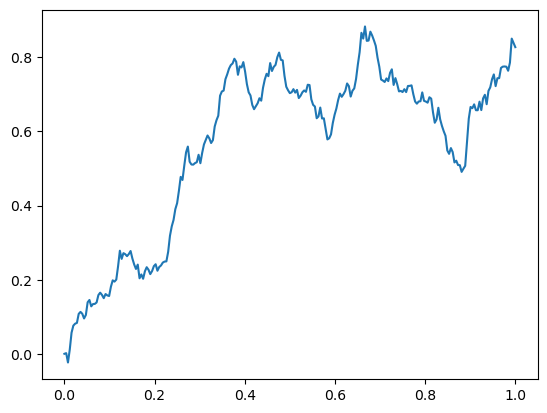

In [4]:
plt.plot(times,fbm_sample)

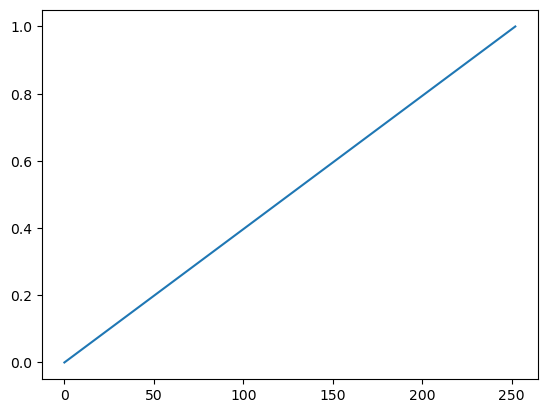

In [25]:
plt.plot(times)

In [88]:
def evol_va(mu,sigma_a,fbm_sample,times,H):
    VA=np.exp( mu*times - ((sigma_a**2)/2)*(times**(2*H)) + sigma_a*fbm_sample)
    return(VA)



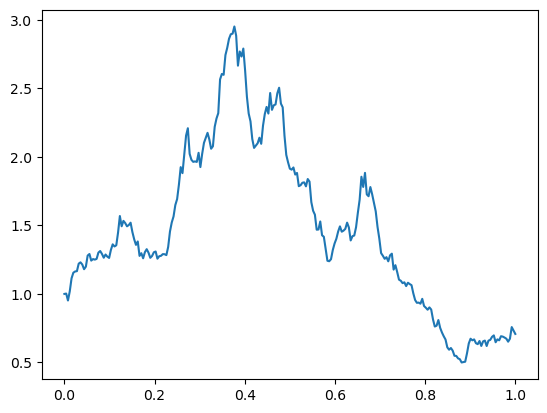

In [47]:
plt.plot(times,evol_va(0,2,fbm_sample,times,0.7))


In [19]:
def genhurst(S, q):
    
    # Obtient la longueur de la série temporelle
    L = len(S)

    # Avertissement si la série temporelle est très courte (moins de 100 points)
    #if L < 100:
    #    warnings.warn('Data series very short!')

    # Initialisation d'un tableau H pour stocker les résultats du coefficient de Hurst
    H = np.zeros((len(range(5, 20)), 1))  # Crée un tableau de zéros de forme (15, 1)
    k = 0  # Initialise un compteur

    # Boucle sur différentes fenêtres de temps (Tmax)
    for Tmax in range(5, 20):

        # Génère une séquence de nombres de 1 à Tmax
        x = np.arange(1, Tmax + 1, 1)

        # Initialise un tableau mcord pour stocker les résultats locaux du coefficient de Hurst
        mcord = np.zeros((Tmax, 1))  # Crée un tableau de zéros de forme (Tmax, 1)

        # Boucle à travers les décalages temporels (tt) dans la fenêtre actuelle
        for tt in range(1, Tmax + 1):

            # Calcule les différences et les valeurs retardées
            dV = S[np.arange(tt, L, tt)] - S[np.arange(tt, L, tt) - tt]
            VV = S[np.arange(tt, L + tt, tt) - tt]
            N = len(dV) + 1
            X = np.arange(1, N + 1, dtype=np.float64)
            Y = VV

            # Calcul des coefficients pour ajuster une droite
            mx = np.sum(X) / N
            SSxx = np.sum(X**2) - N * mx**2
            my = np.sum(Y) / N
            SSxy = np.sum(np.multiply(X, Y)) - N * mx * my
            cc1 = SSxy / SSxx
            cc2 = my - cc1 * mx
            ddVd = dV - cc1
            VVVd = VV - np.multiply(cc1, np.arange(1, N + 1, dtype=np.float64)) - cc2

            # Calcul du coefficient de Hurst local
            mcord[tt - 1] = np.mean(np.abs(ddVd)**q) / np.mean(np.abs(VVVd)**q)

        # Régression linéaire sur le logarithme des échelles
        mx = np.mean(np.log10(x))
        SSxx = np.sum(np.log10(x)**2) - Tmax * mx**2
        my = np.mean(np.log10(mcord))
        SSxy = np.sum(np.multiply(np.log10(x), np.transpose(np.log10(mcord)))) - Tmax * mx * my

        # Stocke le résultat du coefficient de Hurst dans le tableau H
        H[k] = SSxy / SSxx
        k = k + 1

    # Calcule la moyenne des coefficients de Hurst sur toutes les fenêtres de temps et divise par q
    mH = np.mean(H) / q

    return mH  # Retourne le coefficient de Hurst moyen divisé par l'ordre q

In [22]:
genhurst(evol_va(0,1,fbm_sample,times,0.7),2)

0.6515284396699083

In [81]:

def find_H(VA):
    n = VA.shape[0]

    delta_t=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    frequency = []
    for d in delta_t:
        frequency.append(n // d)
    
    #resampe with different frequencies
    asset_values={}
    for f in frequency:
        fasset_values = []
        days = []
        for i in range(n):
            if i % (n // f) == 0 :
                days.append(i)
        for day in days:
            fasset_values.append(VA[day])
        asset_values[f] = fasset_values

    #calculate Variance and Mean for every frequency
    Var = []
    for i, f in enumerate(frequency):
        Var.append(np.var(np.diff(np.log(asset_values[f]), n=1)) )

    Mean = []
    for i, f in enumerate(frequency):
        Mean.append(np.mean(np.diff(np.log(asset_values[f]), n=1)))
    var_tau = np.array(Var)


    # Transformation logarithmique
    log_delta_t = np.log(delta_t)
    log_var_tau = np.log(var_tau)

    fixed_intercept_log_sigma2 = np.log(var_tau[0]) # assuming delta = 1 otherwise H is here

    # Régression linéaire
    X = log_delta_t.reshape(-1, 1)
    y = log_var_tau - fixed_intercept_log_sigma2

    model = LinearRegression(fit_intercept=False)
    model.fit(X, y)
    #print('Regression score for H is ',model.score(X, y))

    # Coefficients de la régression
    slope = model.coef_[0]

    # Calcul de H
    H = slope / 2
    sigma_A = np.sqrt(var_tau[0]) * np.sqrt(int(n/delta_t[0]))
    #for i in range(len(delta_t)):
    #    print(np.sqrt(var_tau[i]) * np.sqrt(int(n/delta_t[i])))

    return sigma_A, H

In [28]:
find_H(evol_va(0,1,fbm_sample,times,0.7))

(0.30336079298002966, 0.6818484698474105)

In [51]:
for i in range (10):
    sigma_a=1
    H=0.6
    mu=0

    f = FBM(n=252, hurst=H, length=1, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    print(find_H(evol_va(mu,sigma_a,fbm_sample,times,H)))
    

(0.5951439600872921, 0.5987109683998203)
(0.5594941834644457, 0.5964351147010594)
(0.5868261194881813, 0.5367105793406605)
(0.558908635137512, 0.5820097466489057)
(0.6185594083610021, 0.5945624434253067)
(0.5816295346846875, 0.5636766936716299)
(0.576757351042873, 0.589019096259376)
(0.5852543617329502, 0.4566705865177972)
(0.5697597628521008, 0.5395876098589937)
(0.557100286005788, 0.5375590866651897)


In [72]:
def sigma_error(true_sigma,mu,H,n,n_it=10):

    """
    exp_sigma=np.zeros(n_it)
    err_sigma=np.zeros(n_it)

    
    for i in range (n_it):
        f = FBM(n, hurst=H, length=1, method='daviesharte')
        fbm_sample = f.fbm()
        times = f.times()
        exp_sigma[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
        err_sigma[i]=(exp_sigma[i]-true_sigma)**2

    return (np.mean(exp_sigma),np.mean(err_sigma))
    """
    f = FBM(n, hurst=H, length=1, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    sigma_al=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
    err_sigma=np.abs(sigma_al-true_sigma)
    return(sigma_al,err_sigma)


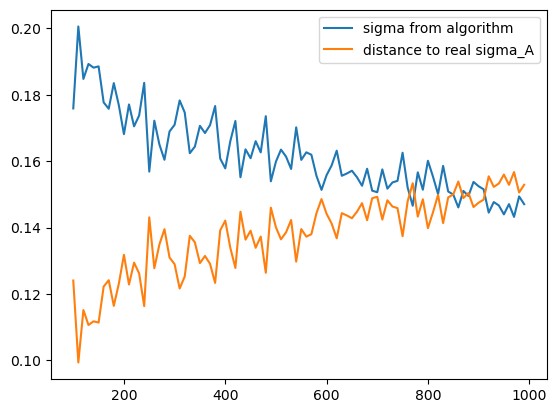

In [92]:
sigma_a=0.3
H=0.6
mu=0

sigma_al=[]
err_sigma=[]
liste_n=[]

for n in range(100,1000,10):
    liste_n.append(n)
    s,e=sigma_error(sigma_a,mu,H,n,n_it=10)
    sigma_al.append(s)
    err_sigma.append(e)

plt.plot(liste_n,sigma_al,label="sigma from algorithm")
plt.plot(liste_n,err_sigma,label="distance to real sigma_A")
plt.legend()


In [89]:
def H_error(sigma_a,mu,H,n,n_it=50):
    
    
    exp_h=np.zeros(n_it)
    err_h=np.zeros(n_it)

    
    for i in range (n_it):
        f = FBM(n, hurst=H, length=1, method='daviesharte')
        fbm_sample = f.fbm()
        times = f.times()
        exp_h[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[1]
        err_h[i]=np.abs(exp_h[i]-H)

    return (np.mean(exp_h),np.mean(err_h))
    """
    f = FBM(n, hurst=H, length=1, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    exp_h=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[1]
    err_h=np.abs(exp_h-H)
    return(exp_h,err_h)
    """

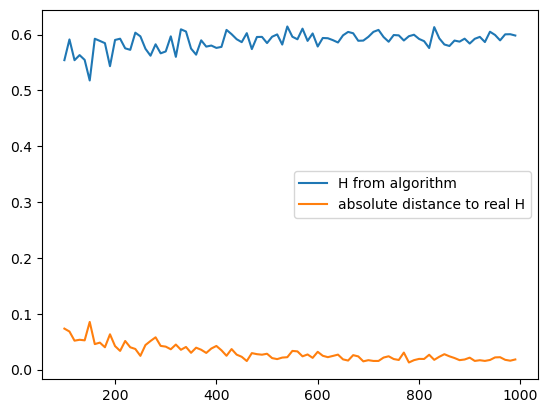

In [90]:
sigma_a=0.3
H=0.6
mu=0

exp_h=[]
err_h=[]
liste_n=[]

for n in range(100,1000,10):
    liste_n.append(n)
    s,e=H_error(sigma_a,mu,H,n,n_it=10)
    exp_h.append(s)
    err_h.append(e)

plt.plot(liste_n,exp_h,label="H from algorithm")

plt.plot(liste_n,err_h,label="absolute distance to real H")
plt.legend()


In [89]:

def find_sigma(VA,H,T):
    n = VA.shape[0]
    X=np.log(VA)

    DX=X[1:]-X[:-1]
    y=((n/T)**H)*DX

    sigma_est= np.sqrt((n/(n-1))*np.var(y))

    return sigma_est

In [94]:
find_sigma(evol_va(0,0.3,fbm_sample,times,0.7),H=0.7,T=1)

0.2884764032744371

In [107]:
def sigma_error2(true_sigma,mu,H,n,n_it=10, T=1):
    
    """
    exp_sigma=np.zeros(n_it)
    err_sigma=np.zeros(n_it)

    
    for i in range (n_it):
        f = FBM(n, hurst=H, length=1, method='daviesharte')
        fbm_sample = f.fbm()
        times = f.times()
        exp_sigma[i]=find_H(evol_va(mu,sigma_a,fbm_sample,times,H))[0]
        err_sigma[i]=(exp_sigma[i]-true_sigma)**2

    return (np.mean(exp_sigma),np.mean(err_sigma))
    """
    f = FBM(n, hurst=H, length=T, method='daviesharte')
    fbm_sample = f.fbm()
    times = f.times()
    VA=evol_va(mu,sigma_a,fbm_sample,times,H)
    sigma_al=find_sigma(VA,H,T)

    err_sigma=np.abs(sigma_al-true_sigma)
    return(sigma_al,err_sigma)


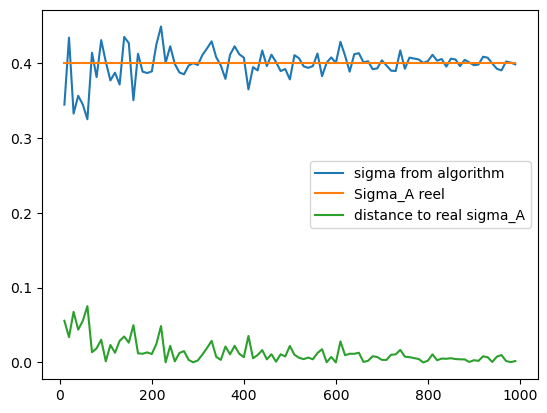

In [110]:
sigma_a=0.4
H=0.6
mu=0
T=1

sigma_al=[]
err_sigma=[]
liste_n=[]
r_s=[]

for n in range(10,252,10):
    liste_n.append(n)
    s,e=sigma_error2(sigma_a,mu,H,n,n_it=10)
    sigma_al.append(s)
    err_sigma.append(e)
    r_s.append(sigma_a)


plt.plot(liste_n,sigma_al,label="sigma from algorithm")
plt.plot(liste_n,r_s,label="Sigma_A reel")


plt.plot(liste_n,err_sigma,label="distance to real sigma_A")
plt.legend()

In [52]:
def mb_gris(s,t,n_steps,H):

    times=np.linspace(s,t,n_steps)
    e = np.random.normal(size=n_steps)

    mbg=((times-s)**H)*e
    return(times,mbg)


In [56]:
times,mbg=mb_gris(0,1,1000,0.5)
mbg.shape

(1000,)

0.5574262315749331


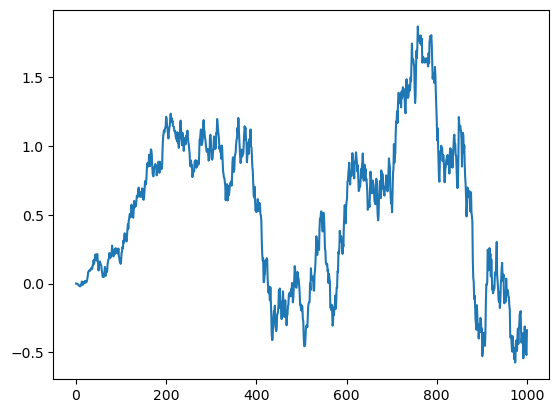

In [67]:
N=100000
times,mbg=mb_gris(0,1,N,0.5)
W=np.zeros(1001)
for k in range (1,1001):
    W[k]=W[k-1]+mbg[k-1]
print(np.sqrt(np.var(W)))
plt.plot(W)

In [68]:
def simulate_asset_price(S0, r, sigma, T, n_steps, n_it):
    dt = T / n_steps
    nudt = (r - 0.5 * sigma**2) * dt
    sigsdt = sigma * np.sqrt(dt)

    S = np.zeros((n_it, n_steps + 1))
    S[:, 0] = S0

    for i in range(n_it):
        #Draw of random walk
        e = np.random.normal(size=n_steps)
        for k in range(1, n_steps + 1):
            S[i, k] = S[i, k - 1] * np.exp(nudt + sigsdt * e[k-1])

    return S

In [70]:
for n in range (1,10000):
S=simulate_asset_price(1, 0, 1, 1, 1000000, 1)
print(np.std(S))

0.1896919985604777


In [ ]:
f = FBM(n=252, hurst=0.7, length=1, method='daviesharte')
"""For fastest performance use the Davies and Harte method. It is much faster than both other methods especially for larger increment quantities.
Note that the Davies and Harte method can fail if the Hurst parameter hurst is close to 1 and there are a small amount of increments n
"""
# Generate a fBm realization
fbm_sample = f.fbm()

# Get the times associated with the fBm
times = f.times()